This notebook demonstrates how to leverage transfer learning to use your own image dataset to build and train an image classification model using MXNet and Amazon SageMaker.

We use, as an example, the creation of a trash classification model which, given some image, classifies it into one of three classes: compost, landfill, recycle. This is based on the [Show Before You Throw](https://www.youtube.com/watch?v=Ut1VGG6TOOw) project from an AWS DeepLens hackathon and the [Smart Recycle Arm](https://www.youtube.com/watch?v=QF0QjRjBwFs) project presented at the AWS Public Sector Summit 2019

--- 

1. [Prerequisites](#Prerequisites)
1. [Download Data](#Download-data)
1. [Fine-tuning the Image Classification Model](#Fine-tuning-the-Image-classification-model)
1. [Start the Training](#Start-the-training)
1. [Test your Model](#Inference)
1. [Deploy your Model to AWS DeepLens](#Deploy)

## Prequisites

- Amazon Sagemaker notebook should have internet access to download images needed for testing this notebook. This is turned ON by default. To explore aoptions review this link : [Sagemaker routing options](https://aws.amazon.com/blogs/machine-learning/understanding-amazon-sagemaker-notebook-instance-networking-configurations-and-advanced-routing-options/)
- The IAM role assigned to this notebook should have permissions to create a bucket (if it does not exist)
  - [IAM role for Amazon Sagemaker](https://docs.aws.amazon.com/glue/latest/dg/create-an-iam-role-sagemaker-notebook.html)
  - [S3 create bucket permissions](https://docs.aws.amazon.com/AmazonS3/latest/dev/using-with-s3-actions.html#using-with-s3-actions-related-to-buckets)

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are 2 parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The Amazon sagemaker image classification docker image which need not be changed

In [ ]:
import os
import urllib.request
import boto3, botocore


import sagemaker
from sagemaker import get_execution_role

import mxnet as mx
mxnet_path = mx.__file__[ : mx.__file__.rfind('/')]
print(mxnet_path)

role = get_execution_role()
print(role)

sess = sagemaker.Session()

## Amazon S3 bucket info
Enter your Amazon S3 Bucket name where your data will be stored, make sure that your SageMaker notebook has access to this S3 Bucket by granting `S3FullAccess` in the SageMaker role attached to this instance. See [here](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-config-permissions.html) for more info.

DeepLens-compatible buckets must start with `deeplens`

In [ ]:
BUCKET = 'deeplens-<Your-Test-Bucket>'
PREFIX = 'deeplens-trash-test'

In [ ]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

We are going to check if we have the right bucket and if we have the right permissions.

Make sure that the result from this cell is "Bucket access is Ok"

In [ ]:
test_data = 'TestData'
s3 = boto3.resource('s3')
object = s3.Object(BUCKET, PREFIX+"/test.txt")
try:
    object.put(Body=test_data)
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "AccessDenied":
        #cannot write on the bucket
        print("Bucket "+BUCKET+"is not writeable, make sure you have the right permissions")
    else:
        if e.response['Error']['Code'] == "NoSuchBucket":
            #Bucket does not exist
            print("Bucket"+BUCKET+" does not exist")
        else:
            raise
else:
    print("Bucket access is Ok")
    object.delete(BUCKET, PREFIX+"/test.txt")

# Prepare data

It is assumed that your custom dataset's images are present in an S3 bucket and that different classes are separated by named folders, as shown in the following directory structure:
```
|-deeplens-bucket
   |-deeplens-trash

    |-images
    
        |-Compost 
    
        |-Landfill
    
        |-Recycle
 ```

we are providing the data for you, first we'll download the example data, unzip it and upload it to your bucket.

In [1]:
!wget https://deeplens-public.s3.amazonaws.com/samples/deeplens-trash/trash-images.zip

--2021-09-27 14:52:13--  https://deeplens-public.s3.amazonaws.com/samples/deeplens-trash/trash-images.zip
Résolution de deeplens-public.s3.amazonaws.com (deeplens-public.s3.amazonaws.com)… 52.217.48.164
Connexion à deeplens-public.s3.amazonaws.com (deeplens-public.s3.amazonaws.com)|52.217.48.164|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 253515836 (242M) [application/zip]
Sauvegarde en : « trash-images.zip »

trash-images.zip    100%[===================>] 241,77M  2,03MB/s    ds 2m 7s   

2021-09-27 14:54:21 (1,91 MB/s) — « trash-images.zip » sauvegardé [253515836/253515836]



In [2]:
!rm -rf data/ && mkdir -p data
!mkdir -p data/images
!unzip -qq trash-images.zip -d data/images
!rm trash-images.zip

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(item_name, images_to_show=-1):
    _im_list = !ls $IMAGES_DIR/$item_name

    NUM_COLS = 3
    if images_to_show == -1:
        IM_COUNT = len(_im_list)
    else:
        IM_COUNT = images_to_show
    
    print('Displaying images category ' + item_name + ' count: ' + str(IM_COUNT) + ' images.')
    
    NUM_ROWS = int(IM_COUNT / NUM_COLS)
    if ((IM_COUNT % NUM_COLS) > 0):
        NUM_ROWS += 1

    fig, axarr = plt.subplots(NUM_ROWS, NUM_COLS)
    fig.set_size_inches(10.0, 10.0, forward=True)

    curr_row = 0
    for curr_img in range(IM_COUNT):
        # fetch the url as a file type object, then read the image
        f = IMAGES_DIR + item_name + '/' + _im_list[curr_img]
        a = plt.imread(f)

        # find the column by taking the current index modulo 3
        col = curr_img % NUM_ROWS
        # plot on relevant subplot
        if NUM_ROWS == 1:
            axarr[curr_row].imshow(a)
        else:
            axarr[col, curr_row].imshow(a)
        if col == (NUM_ROWS - 1):
            # we have finished the current row, so increment row counter
            curr_row += 1

    fig.tight_layout()       
    plt.show()
        
    # Clean up
    plt.clf()
    plt.cla()
    plt.close()

Displaying images category Compost count: 3 images.


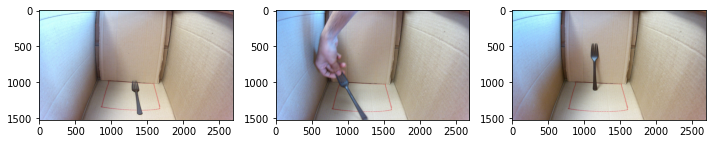

Displaying images category Landfill count: 3 images.


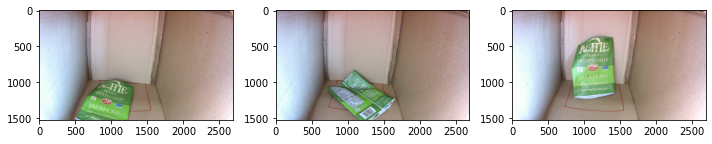

Displaying images category Recycling count: 3 images.


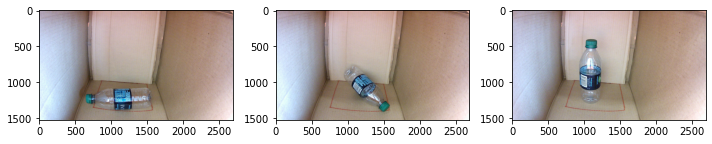

In [6]:
IMAGES_DIR = 'data/images/'
show_images("Compost", images_to_show=3)
show_images("Landfill", images_to_show=3)
show_images("Recycling", images_to_show=3)

In [ ]:
DEST_BUCKET = 's3://'+BUCKET+'/'+PREFIX+'/images/'

In [ ]:
!aws s3 cp --recursive data/images $DEST_BUCKET --quiet

Ensure that the newly created directories containing the downloaded data are structured as shown at the beginning.

In [ ]:
!aws s3 ls $DEST_BUCKET

#### Prepare "list" files with train-val split

The image classification algorithm can take two types of input formats. The first is a [RecordIO format](https://mxnet.apache.org/api/faq/recordio) (content type: application/x-recordio) and the other is a Image list format (.lst file). These file formats allows for efficient loading of images when training the model. We will be using the Image list format (.lst file). A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The RecordIO file contains the actual pixel data for the images.

To be able to create the .rec files, we first need to split the data into training and validation sets (after shuffling) and create two list files for each. Here our split into train, validation and test (specified by the `0.7` parameter below for test). We keep 0.02% to test the model.

The image and lst files will be converted to RecordIO file internally by the image classification algorithm. But if you want do the conversion, the following cell shows how to do it using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool. Note that this is just an example of creating RecordIO files. We are **_not_** using them for training in this notebook.

In [ ]:
!python $mxnet_path/tools/im2rec.py --list --recursive --test-ratio=0.02 --train-ratio 0.7 trash data/images

## Save lst files to S3
Training models is easy with Amazon SageMaker. When you’re ready to train in SageMaker, simply specify the location of your data in Amazon S3, and indicate the type and quantity of SageMaker ML instances you need. SageMaker sets up a distributed compute cluster, performs the training, outputs the result to Amazon S3, and tears down the cluster when complete. 
To use Amazon Sagemaker training we must first transfer our input data to Amazon S3.

In [ ]:
s3train_lst = 's3://{}/{}/train_lst/'.format(BUCKET, PREFIX)
s3validation_lst = 's3://{}/{}/validation_lst/'.format(BUCKET, PREFIX)

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp trash_train.lst $s3train_lst --quiet
!aws s3 cp trash_val.lst $s3validation_lst --quiet

#### Retrieve dataset size

Let's see the size of train, validation and test datasets

In [ ]:
f = open('trash_train.lst', 'r')
train_samples = sum(1 for line in f)
f.close()
f = open('trash_val.lst', 'r')
val_samples = sum(1 for line in f)
f.close()
f = open('trash_test.lst', 'r')
test_samples = sum(1 for line in f)
f.close()
print('train_samples:', train_samples)
print('val_samples:', val_samples)
print('test_samples:', test_samples)

This marks the end of the data preparation phase.

# Train the model

Training a good model from scratch can take a long time. Fortunately, we're able to use transfer learning to fine-tune a model that has been trained on millions of images. Transfer learning allows us to train a model to recognize new classes in minutes instead of hours or days that it would normally take to train the model from scratch. Transfer learning requires a lot less data to train a model than from scratch (hundreds instead of tens of thousands).

## Fine-tuning the Image Classification Model
Now that we are done with all the setup that is needed, we are ready to train our trash detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [ ]:
s3_output_location = 's3://{}/{}/output'.format(BUCKET, PREFIX)
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess,
                                         base_job_name='ic-trash')

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. For us, we have 
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode


In [ ]:
ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=3,
                             mini_batch_size=128,
                             epochs=10,
                             learning_rate=0.01,
                             top_k=2,
                             num_training_samples=train_samples,
                             resize = 224,
                             precision_dtype='float32')

## Input data specification
Set the data type and channels used for training

In [ ]:
s3images = 's3://{}/{}/images/'.format(BUCKET, PREFIX)

train_data = sagemaker.session.s3_input(s3images, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3images, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

## Start the training
Start training by calling the fit method in the estimator

In [ ]:
ic.fit(inputs=data_channels, logs=True)

#### The output from the above command will have the model accuracy and the time it took to run the training. 
#### You can also view these details by navigating to ``Training -> Training Jobs -> job_name -> View logs`` in the Amazon SageMaker console 

The model trained above can now be found in the `s3://<YOUR_BUCKET>/<PREFIX>/output` path.

In [ ]:
MODEL_PATH = ic.model_data
print(MODEL_PATH)

## Deploy to a Sagemaker endpoint
After training your model is complete, you can test your model by asking it to predict the class of a sample trash image that the model has not seen before. This step is called inference.

Amazon SageMaker provides an HTTPS endpoint where your machine learning model is available to provide inferences. For more information see the [Amazon SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [ ]:
ic_infer = ic.deploy(initial_instance_count=1, instance_type='local')

## Test the images against the endpoint
We will use the test images that were kept aside for testing.

In [ ]:
object_categories = ['Compost', 'Landfill', 'Recycling']

In [ ]:
from IPython.display import Image, display
import json
import numpy as np


def test_model():
    preds = []
    acts  = []
    num_errors = 0
    with open('trash_test.lst', 'r') as f:
        for line in f:
            stripped_line = str(line.strip()).split("\t")
            file_path = stripped_line[2]
            category = int(float(stripped_line[1]))
            with open(IMAGES_DIR + stripped_line[2], 'rb') as f:
                payload = f.read()
                payload = bytearray(payload)

                ic_infer.content_type = 'application/x-image'
                result = json.loads(ic_infer.predict(payload))
            # the result will output the probabilities for all classes
            # find the class with maximum probability and print the class index
            index = np.argmax(result)
            act = object_categories[category]
            pred = object_categories[index]
            conf = result[index]
            print("Result: Predicted: {}, Confidence: {:.2f}, Actual: {} ".format(pred, conf, act))
            acts.append(category)
            preds.append(index)
            if (pred != act):
                num_errors += 1
                print('ERROR on image -- Predicted: {}, Confidence: {:.2f}, Actual: {}'.format(pred, conf, act))
            display(Image(filename=IMAGES_DIR + stripped_line[2], width=100, height=100))

    return num_errors, preds, acts
num_errors, preds, acts = test_model()

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
COLOR = 'green'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
def plot_confusion_matrix(cm, classes,
                          class_name_list,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.figure(figsize=(7,7))
    plt.grid(False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.gca().set_xticklabels(class_name_list)
    plt.gca().set_yticklabels(class_name_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def create_and_plot_confusion_matrix(actual, predicted):
    cnf_matrix = confusion_matrix(actual, np.asarray(predicted),labels=range(len(object_categories)))
    plot_confusion_matrix(cnf_matrix, classes=range(len(object_categories)), class_name_list=object_categories)

## Display confusion matrix showing 'true' and 'predicted' labels

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. It's a table  with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table). The diagonal values in the table indicate a match between the predicted class and the actual class. 

For more details go to [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) (Wikipedia)

In [ ]:
create_and_plot_confusion_matrix(acts, preds)

## (Optional) Clean-up

This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sess.delete_endpoint(ic_infer.endpoint)
print("Completed")

## Rename model to deploy to AWS DeepLens
The MxNet model that is stored in the S3 bucket contains 2 files: the params file and a symbol.json file. To simplify deployment to AWS DeepLens, we'll modify the params file so that you do not need to specify the number of epochs the model was trained for.

In [ ]:
import glob

In [ ]:
!rm -rf data/$PREFIX/tmp && mkdir -p data/$PREFIX/tmp
!aws s3 cp $MODEL_PATH data/$PREFIX/tmp
!tar -xzvf data/$PREFIX/tmp/model.tar.gz -C data/$PREFIX/tmp

In [ ]:
params_file_name = glob.glob('./data/' + PREFIX + '/tmp/*.params')[0]

In [ ]:
!mv $params_file_name data/$PREFIX/tmp/image-classification-0000.params

In [ ]:
!tar -cvzf ./model.tar.gz -C data/$PREFIX/tmp ./image-classification-0000.params ./image-classification-symbol.json

In [ ]:
!aws s3 cp model.tar.gz $MODEL_PATH